# Advanced Training Configuration for the autoregressive Lorenz emulator

This notebook assumes that you already familiar with the `lorenz_emulator.ipynb`
notebook.

We will use some of the more advanced features of `Trainax` to perform
**unrolled training**. Instead of having the emulator predict one step into the
future during trainig, it will autoregressively predict a few steps. This more
closely aligns with its inference task of long-term stability and accuracy. We
will consider two flavors of unrolled training:

1. **Supervised Unrolling**: The emulator produces a trajectory autoregressively
   during training and this trajectory is then compared to a reference trajectory
   of the same length starting from the same initial condition.
2. **Diverted-Chain Unrolling** (with branch length one): The reference
   simulator branches off from the emulator's trajectory after each step and
   creates a one-step reference.

In contrast to the previous notebook, we will also a $\Delta t = 0.01$ instead
of $0.05$ which follows the original work of [Lorenz
(1963)](https://doi.org/10.1175/1520-0469(1963)020%3C0130:DNF%3E2.0.CO;2).

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import equinox as eqx

In [2]:
import trainax as tx

/home/koehler/Repos/trainax/trainax/_general_trainer.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Below is the same convenience data generation of before, but this time, the
$\Delta t$ is not altered and we use the default of $0.01$.

In [3]:
lorenz_data_trj = tx.sample_data.lorenz_rk4(
    num_samples=9, key=jax.random.PRNGKey(0), temporal_horizon=5000
)
# (num_trjs, num_steps, num_dofs=3)
lorenz_data_trj.shape

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(9, 5000, 3)

As a sanity check, visualize all nine trajectories. Notice that they are way
smoother than in the previous notebook (due to the smaller time step).

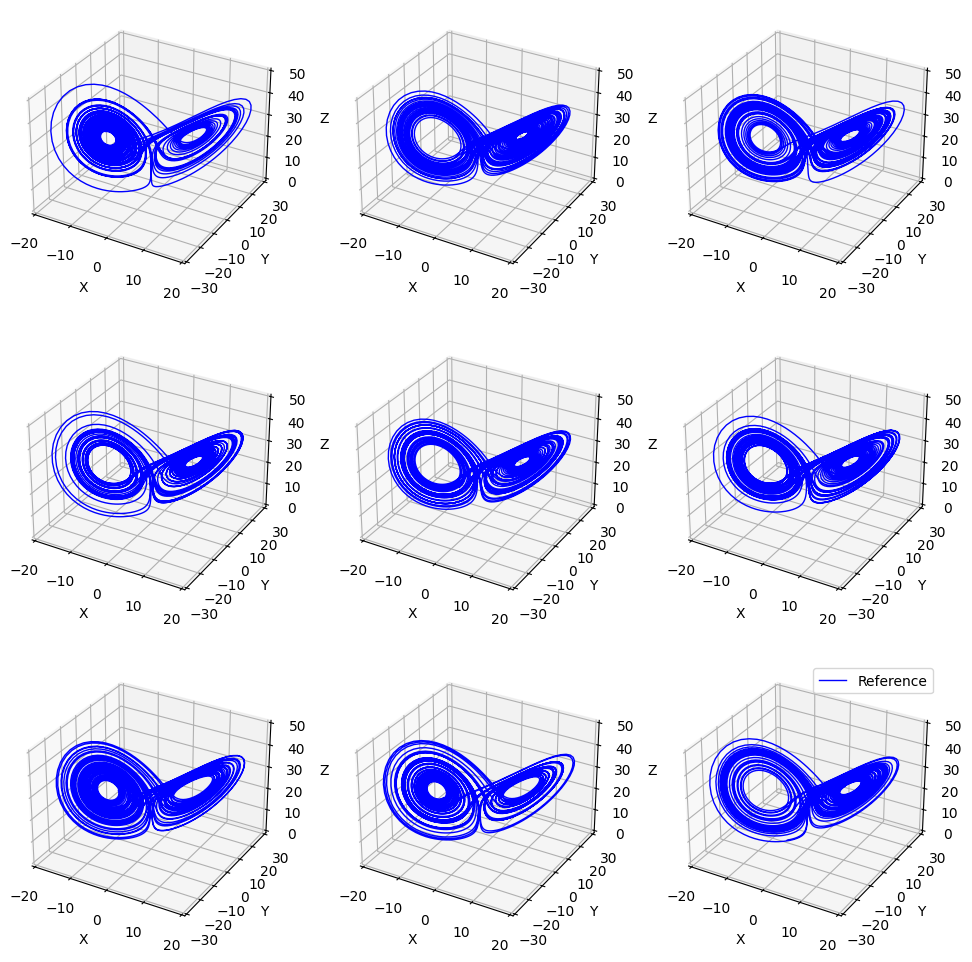

In [4]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

STEPS_TO_PLOT = -1
for i, ax in enumerate(axs.flat):
    ax.plot(
        lorenz_data_trj[i, :STEPS_TO_PLOT, 0],
        lorenz_data_trj[i, :STEPS_TO_PLOT, 1],
        lorenz_data_trj[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="blue",
        label="Reference",
    )
    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
plt.legend()

A sanity check that the trajectories are free from diverged values.

In [5]:
# Check for the presence of NaNs
jnp.any(jnp.isnan(lorenz_data_trj))

Array(False, dtype=bool)

In its original work, [Lorenz
(1963)](https://doi.org/10.1175/1520-0469(1963)020%3C0130:DNF%3E2.0.CO;2)
assessed the properties of the Lorenz system by a scatter plot of the
consecutive values of two relative maxima in the z variable.

![](lorenz_63_consecutive_maxima_in_z.png)

(Note that both axes are scaled by $100$.)

We will use this to evaluate the emulator's performance.

In [6]:
def find_maximum_z(trj):
    """Cannot be vmapped, because the size of the returned array is inconsistent."""
    z_trj_left = trj[:-2, 2]
    z_trj_center = trj[1:-1, 2]
    z_trj_right = trj[2:, 2]

    # Is True if that corresponding index is a relative maximum
    is_maximum = jnp.logical_and(z_trj_center > z_trj_left, z_trj_center > z_trj_right)
    maximal_values = z_trj_center[is_maximum]
    return maximal_values

We need to use a list comprehension to go over all the nine trajectories since
the `find_maximum_z` function is inconsistent in its return shape (hence we
cannot use `jax.vmap` on it).

In [7]:
maximal_values = [find_maximum_z(trj) for trj in lorenz_data_trj]

Across the trajectories, the pattern closely follows the original work of Lorenz
(1963).

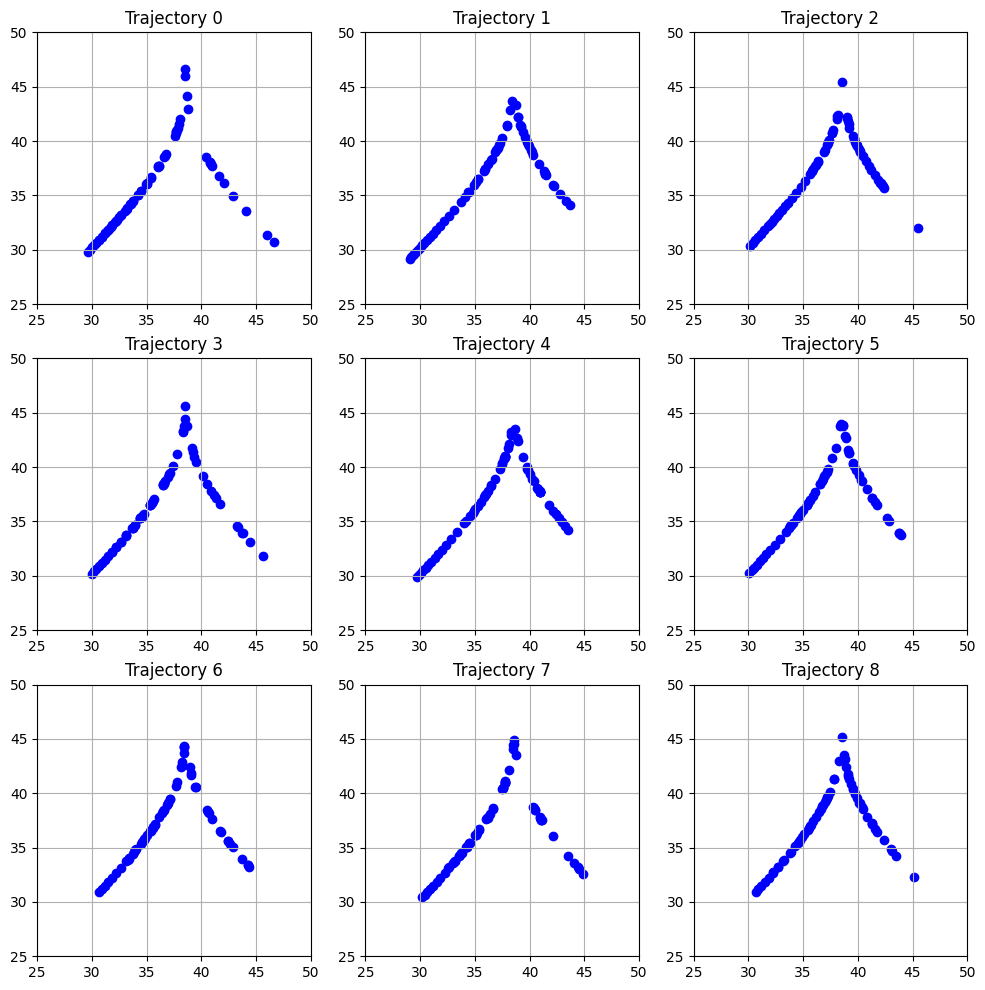

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    ax.scatter(maximal_values[i][:-1], maximal_values[i][1:], color="blue")
    ax.set_title(f"Trajectory {i}")
    ax.set_xlim(25, 50)
    ax.set_ylim(25, 50)
    ax.grid()

Let's have all the scatter plots in one figure.

Now the scatter plots are more densely packed. Similar to the image taken from
Lorenz (1963), the peak is slightly above 45 and the density of points is higher
on the left half of the arc than on the right half.

Also, there is very little (if even noticeable) deviation from a shared line.

(25.0, 50.0)

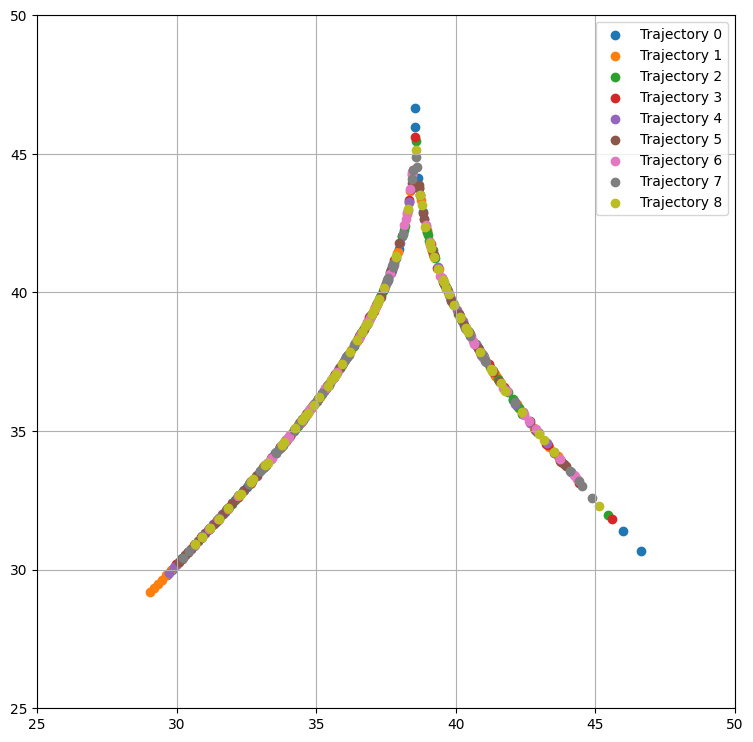

In [9]:
plt.figure(figsize=(9, 9))

for i in range(9):
    plt.scatter(maximal_values[i][:-1], maximal_values[i][1:], label=f"Trajectory {i}")

plt.grid()
plt.legend()
plt.xlim(25, 50)
plt.ylim(25, 50)

## Setup

The emulator used across all examples will be a simple feedforward neural like
before, but a bit larger.

In [10]:
emulator = eqx.nn.MLP(3, 3, 160, 8, jax.nn.relu, key=jax.random.PRNGKey(0))

Later, we will again need this rollout transformation.

In [11]:
def rollout(stepper, n, *, include_init: bool = False):
    def scan_fn(u, _):
        u_next = stepper(u)
        return u_next, u_next

    def rollout_fn(u_0):
        _, trj = jax.lax.scan(scan_fn, u_0, None, length=n)

        if include_init:
            return jnp.concatenate([jnp.expand_dims(u_0, axis=0), trj], axis=0)

        return trj

    return rollout_fn

## One-Step Supervised Training

For reference, we will again used a one-step supervised trained emulator.

In [12]:
sup_1_trainer = tx.trainer.SupervisedTrainer(
    lorenz_data_trj,
    optimizer=optax.adam(
        optax.warmup_cosine_decay_schedule(0.0, 3e-4, 3000, 20000)
    ),  # This learning rate is scheduler is different from before
    num_training_steps=20_000,
    batch_size=64,
    num_rollout_steps=1,
)

In [13]:
sup_1_trained_emu, sup_1_loss_history = sup_1_trainer(emulator, jax.random.PRNGKey(0))

E: 00000, B: 00000:   0%|          | 0/20000 [00:00<?, ?it/s]

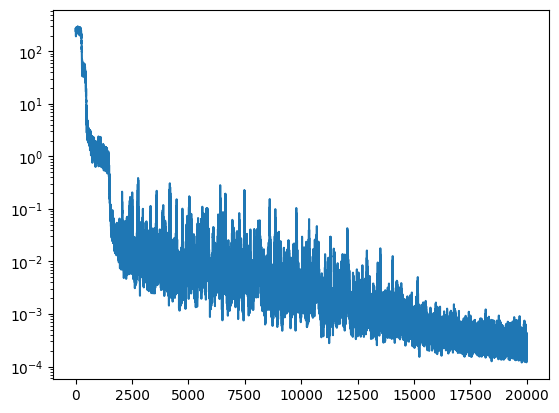

In [14]:
plt.semilogy(sup_1_loss_history)

In [15]:
sup_1_emulator_trj = jax.vmap(
    rollout(sup_1_trained_emu, lorenz_data_trj.shape[1] - 1, include_init=True)
)(lorenz_data_trj[:, 0, :])
sup_1_emulator_trj.shape

(9, 5000, 3)

The sample rollout performance of the one-step supervised trained emulator is
worse than in the previous notebook.

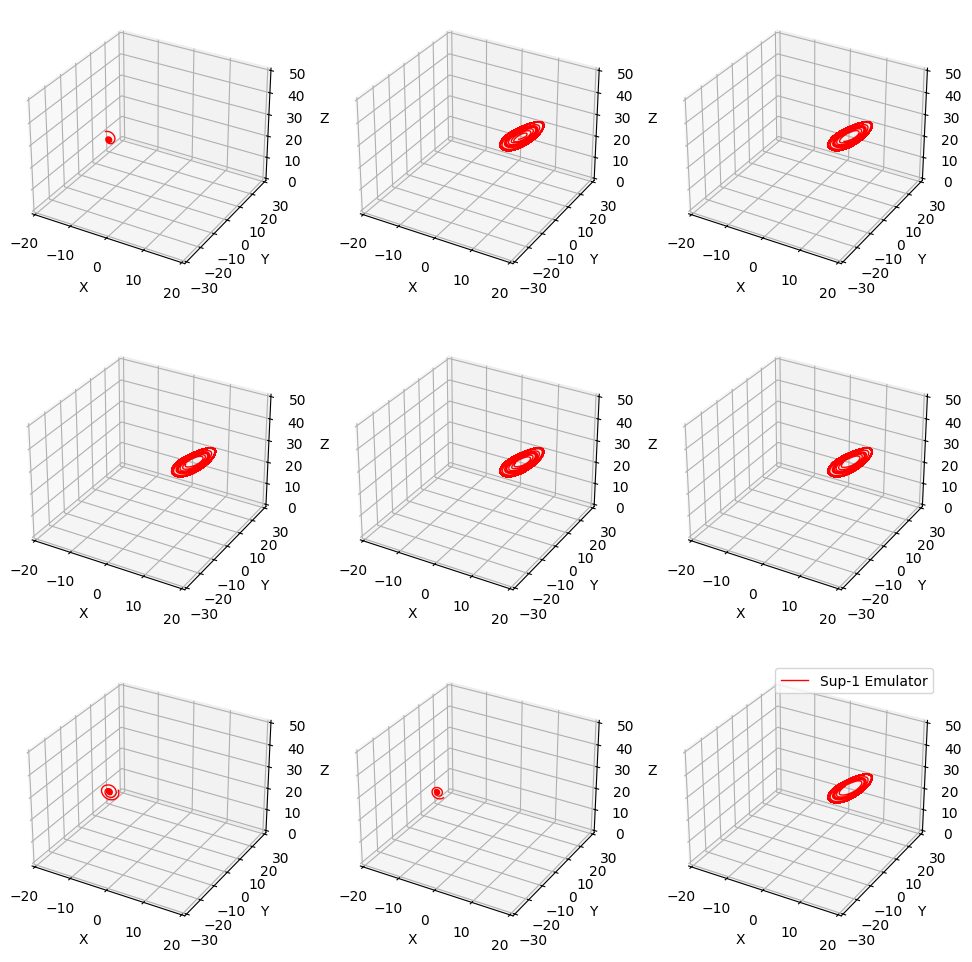

In [16]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

STEPS_TO_PLOT = -1
for i, ax in enumerate(axs.flat):
    ax.plot(
        sup_1_emulator_trj[i, :STEPS_TO_PLOT, 0],
        sup_1_emulator_trj[i, :STEPS_TO_PLOT, 1],
        sup_1_emulator_trj[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="red",
        label="Sup-1 Emulator",
    )
    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
plt.legend()

In [17]:
sup_1_maximal_values = [find_maximum_z(trj) for trj in sup_1_emulator_trj]

This is also reflected in the scatter plots of the consecutive maxima in z.

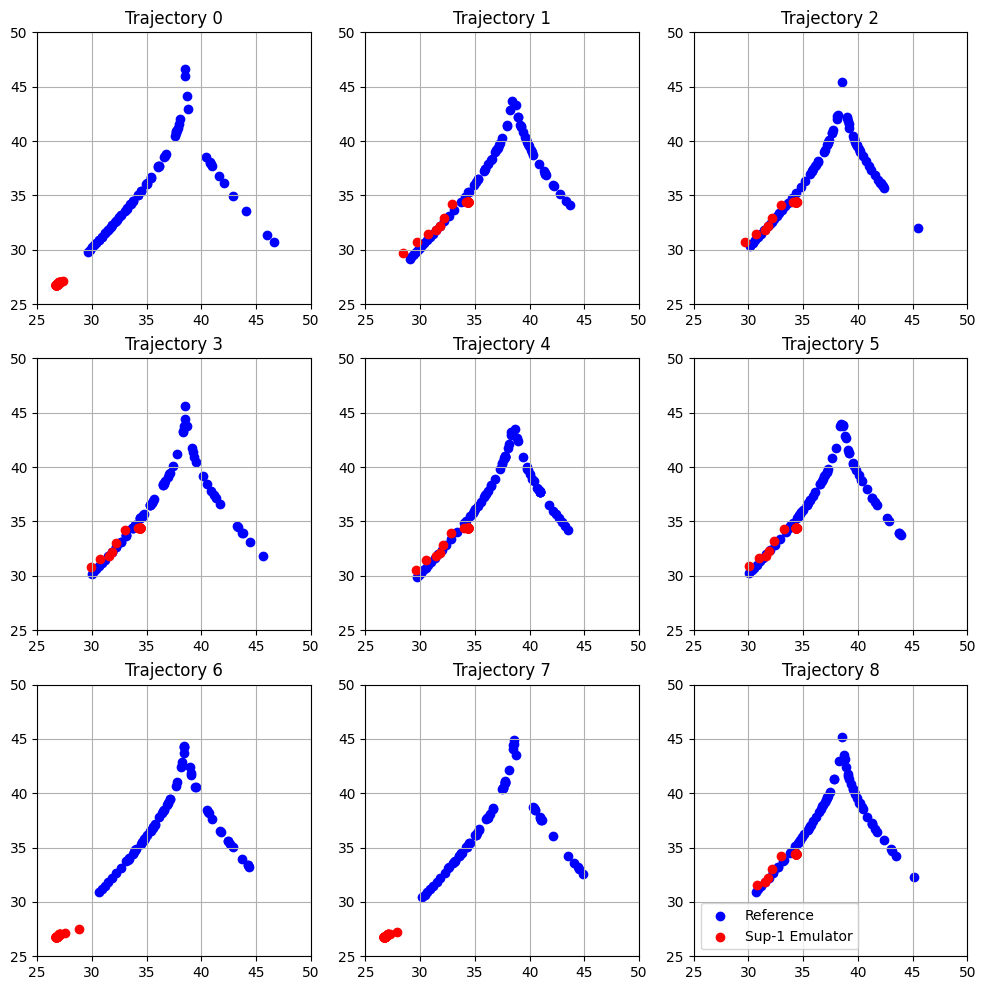

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    ax.scatter(
        maximal_values[i][:-1], maximal_values[i][1:], color="blue", label="Reference"
    )
    ax.scatter(
        sup_1_maximal_values[i][:-1],
        sup_1_maximal_values[i][1:],
        color="red",
        label="Sup-1 Emulator",
    )
    ax.set_title(f"Trajectory {i}")
    ax.set_xlim(25, 50)
    ax.set_ylim(25, 50)
    ax.grid()
plt.legend()

## Five Steps Supervised Training

Now, we will train the emulator to predict five steps into the future with the
loss being computed against a reference trajectory of similar length.

In [19]:
sup_5_trainer = tx.trainer.SupervisedTrainer(
    lorenz_data_trj,
    optimizer=optax.adam(optax.warmup_cosine_decay_schedule(0.0, 3e-4, 3000, 20000)),
    num_training_steps=20_000,
    batch_size=64,
    num_rollout_steps=5,
)

In [20]:
sup_5_trained_emu, sup_5_loss_history = sup_5_trainer(emulator, jax.random.PRNGKey(0))

E: 00000, B: 00000:   0%|          | 0/20000 [00:00<?, ?it/s]

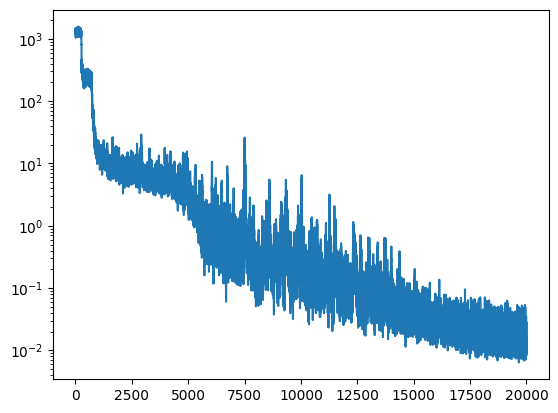

In [21]:
plt.semilogy(sup_5_loss_history)

In [22]:
sup_5_emulator_trj = jax.vmap(
    rollout(sup_5_trained_emu, lorenz_data_trj.shape[1] - 1, include_init=True)
)(lorenz_data_trj[:, 0, :])
sup_5_emulator_trj.shape

(9, 5000, 3)

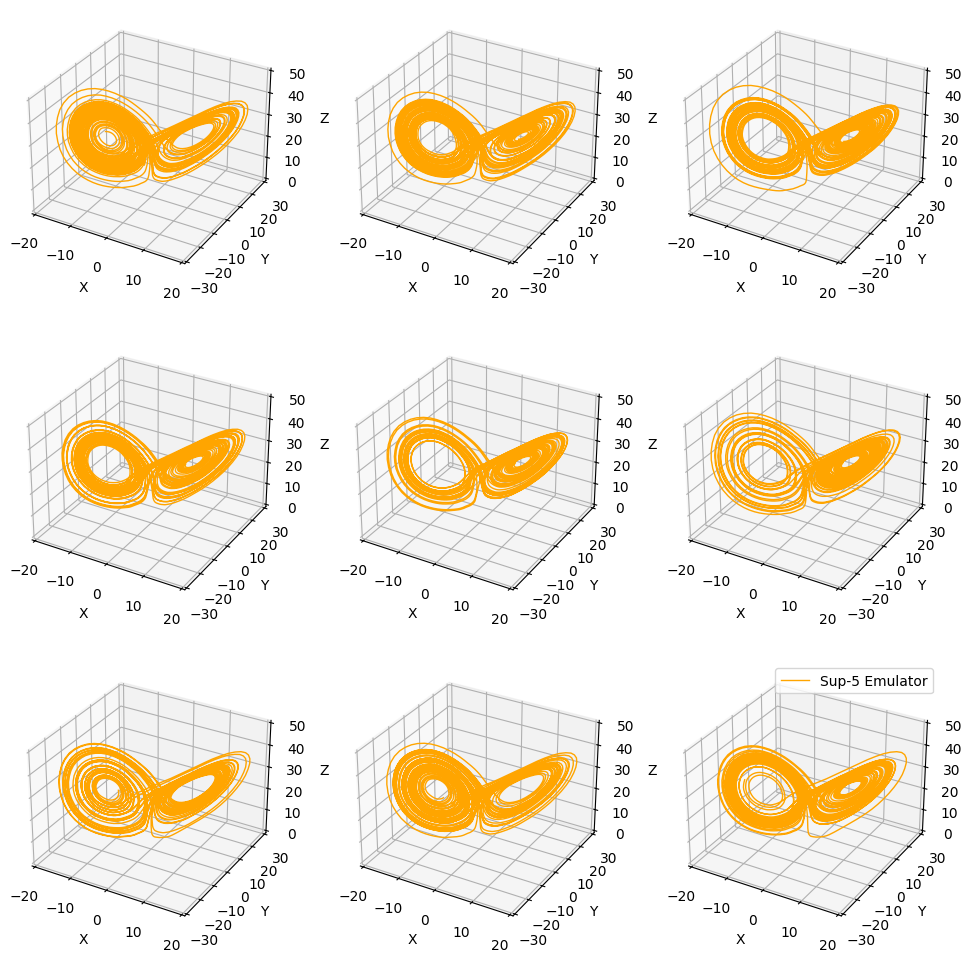

In [23]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

STEPS_TO_PLOT = -1
for i, ax in enumerate(axs.flat):
    ax.plot(
        sup_5_emulator_trj[i, :STEPS_TO_PLOT, 0],
        sup_5_emulator_trj[i, :STEPS_TO_PLOT, 1],
        sup_5_emulator_trj[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="orange",
        label="Sup-5 Emulator",
    )
    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
plt.legend()

In [24]:
sup_5_maximal_values = [find_maximum_z(trj) for trj in sup_5_emulator_trj]

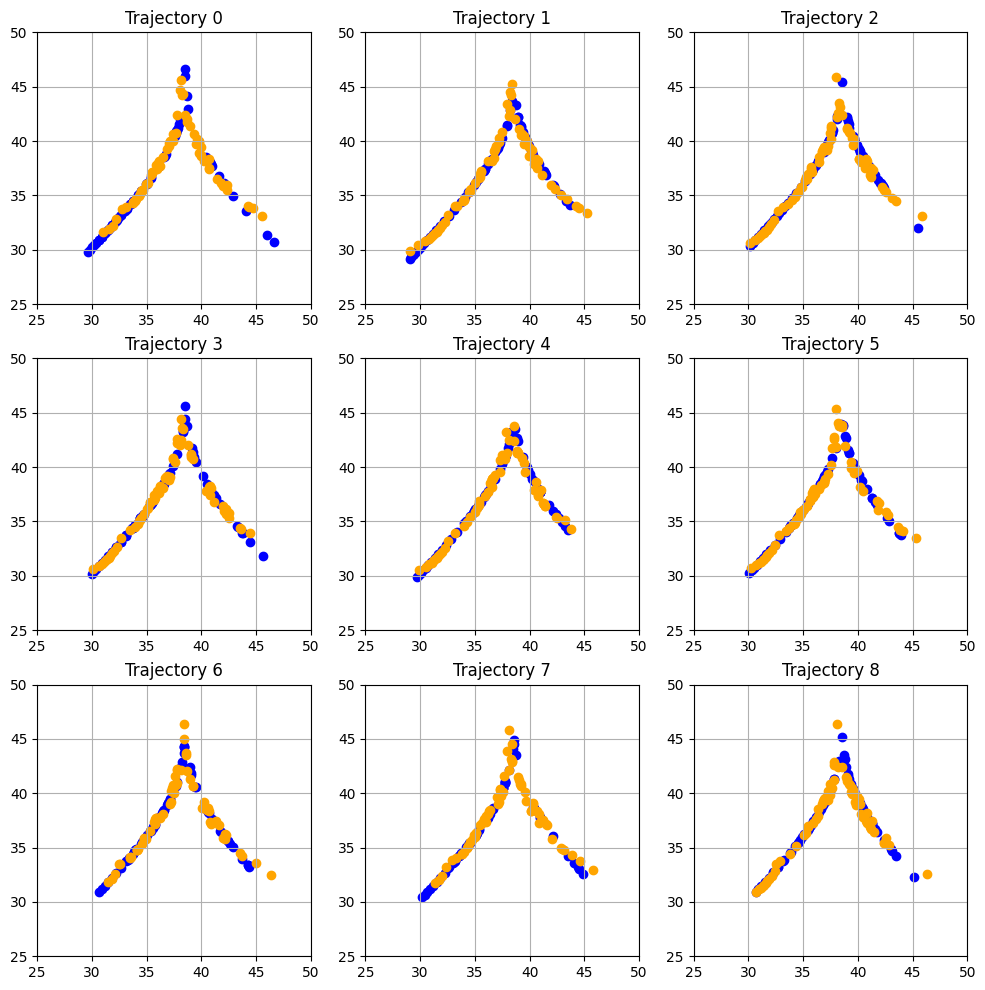

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    ax.scatter(
        maximal_values[i][:-1], maximal_values[i][1:], color="blue", label="Reference"
    )
    ax.scatter(
        sup_5_maximal_values[i][:-1],
        sup_5_maximal_values[i][1:],
        color="orange",
        label="Sup-5 Emulator",
    )
    ax.set_title(f"Trajectory {i}")
    ax.set_xlim(25, 50)
    ax.set_ylim(25, 50)
    ax.grid()

## Five Steps Diverted Chain Training

Diverted Chain training requires the reference simulator during learning. It
also has to be differentiable.

In [26]:
lorenz_stepper = tx.sample_data.make_lorenz_stepper_rk4()

Let's check that this is indeed the simulator used to create the data.

In [27]:
jnp.allclose(lorenz_data_trj[0, 1], lorenz_stepper(lorenz_data_trj[0, 0]))

Array(True, dtype=bool)

In [28]:
div_one_5_trainer = tx.trainer.DivertedChainBranchOneTrainer(
    lorenz_data_trj,
    optimizer=optax.adam(optax.warmup_cosine_decay_schedule(0.0, 3e-4, 3000, 20000)),
    num_training_steps=20_000,
    batch_size=64,
    num_rollout_steps=5,
    ref_stepper=lorenz_stepper,
)

In [29]:
div_one_5_trained_emu, div_one_5_loss_history = div_one_5_trainer(
    emulator, jax.random.PRNGKey(0)
)

E: 00000, B: 00000:   0%|          | 0/20000 [00:00<?, ?it/s]

Text(0, 0.5, 'Train Loss')

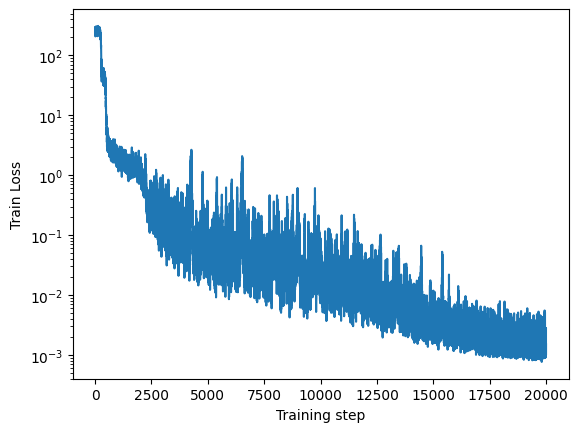

In [30]:
plt.semilogy(div_one_5_loss_history)
plt.xlabel("Training step")
plt.ylabel("Train Loss")

In [31]:
div_one_5_emulator_trj = jax.vmap(
    rollout(div_one_5_trained_emu, lorenz_data_trj.shape[1] - 1, include_init=True)
)(lorenz_data_trj[:, 0, :])

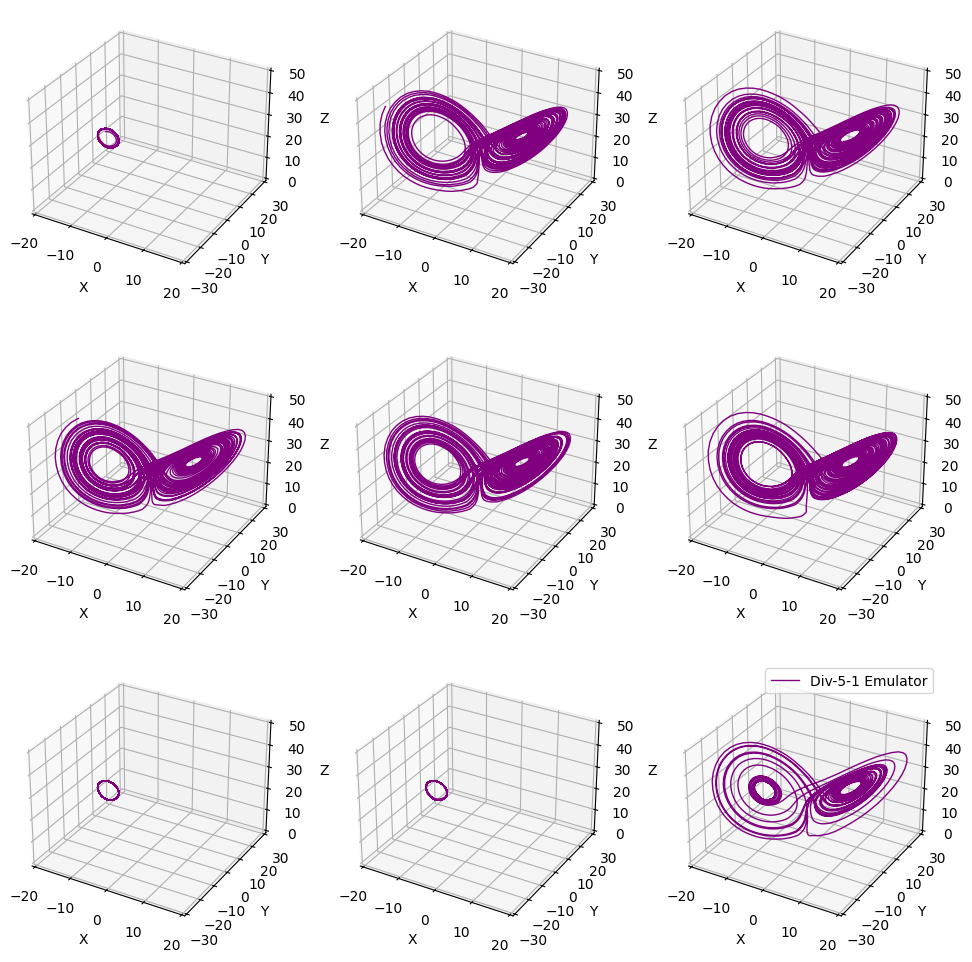

In [32]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

STEPS_TO_PLOT = -1
for i, ax in enumerate(axs.flat):
    ax.plot(
        div_one_5_emulator_trj[i, :STEPS_TO_PLOT, 0],
        div_one_5_emulator_trj[i, :STEPS_TO_PLOT, 1],
        div_one_5_emulator_trj[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="purple",
        label="Div-5-1 Emulator",
    )
    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
plt.legend()

In [33]:
div_one_5_maximal_values = [find_maximum_z(trj) for trj in div_one_5_emulator_trj]

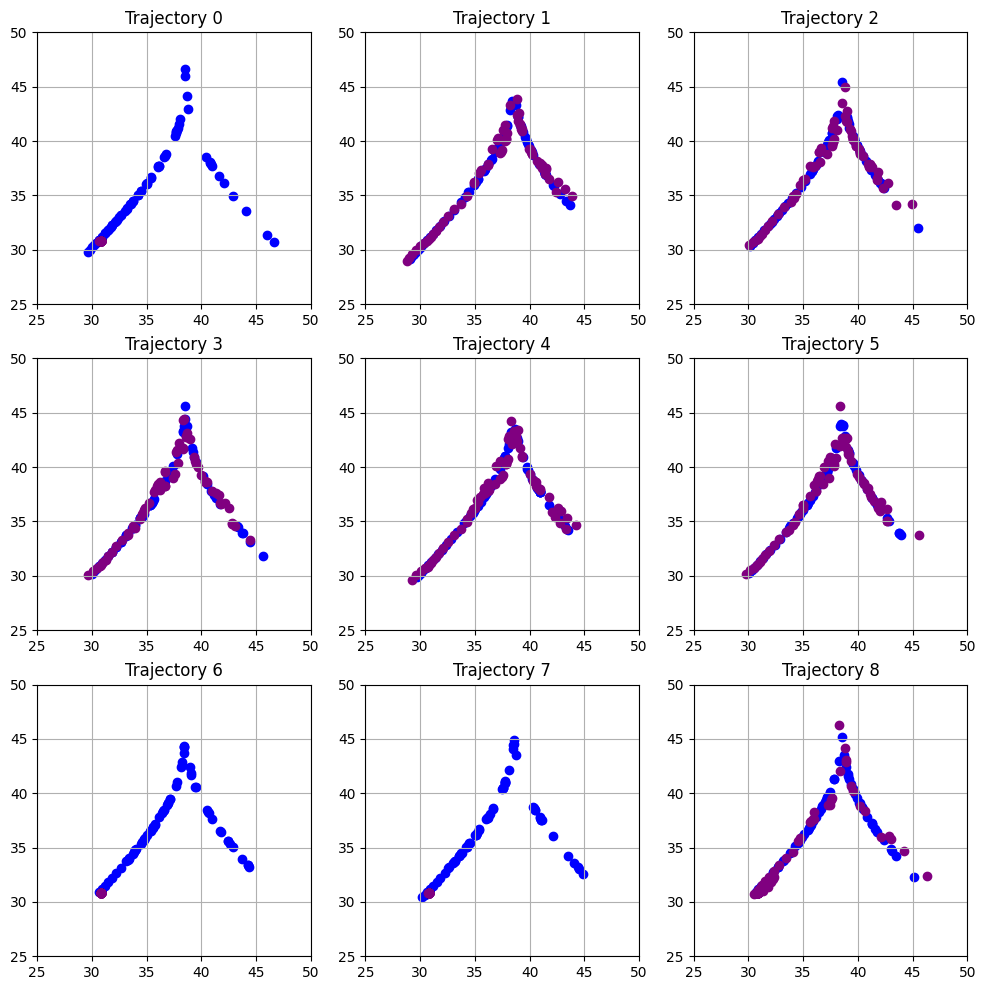

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    ax.scatter(
        maximal_values[i][:-1], maximal_values[i][1:], color="blue", label="Reference"
    )
    ax.scatter(
        div_one_5_maximal_values[i][:-1],
        div_one_5_maximal_values[i][1:],
        color="purple",
        label="Div-5-1 Emulator",
    )
    ax.set_title(f"Trajectory {i}")
    ax.set_xlim(25, 50)
    ax.set_ylim(25, 50)
    ax.grid()

## One-Step Supervised with compensated batch size

In [35]:
sup_1_trainer_compensate_batch_size = tx.trainer.SupervisedTrainer(
    lorenz_data_trj,
    optimizer=optax.adam(optax.warmup_cosine_decay_schedule(0.0, 3e-4, 3000, 20000)),
    num_training_steps=20_000,
    batch_size=64
    * 5,  # Five times as large because the other two models are trained with 5 unrolled steps
    num_rollout_steps=1,
)

In [36]:
(
    sup_1_trained_emu_compensate_batch_size,
    sup_1_loss_history_compensate_batch_size,
) = sup_1_trainer_compensate_batch_size(emulator, jax.random.PRNGKey(0))

E: 00000, B: 00000:   0%|          | 0/20000 [00:00<?, ?it/s]

In [37]:
sup_1_emulator_trj_compensate_batch_size = jax.vmap(
    rollout(
        sup_1_trained_emu_compensate_batch_size,
        lorenz_data_trj.shape[1] - 1,
        include_init=True,
    )
)(lorenz_data_trj[:, 0, :])

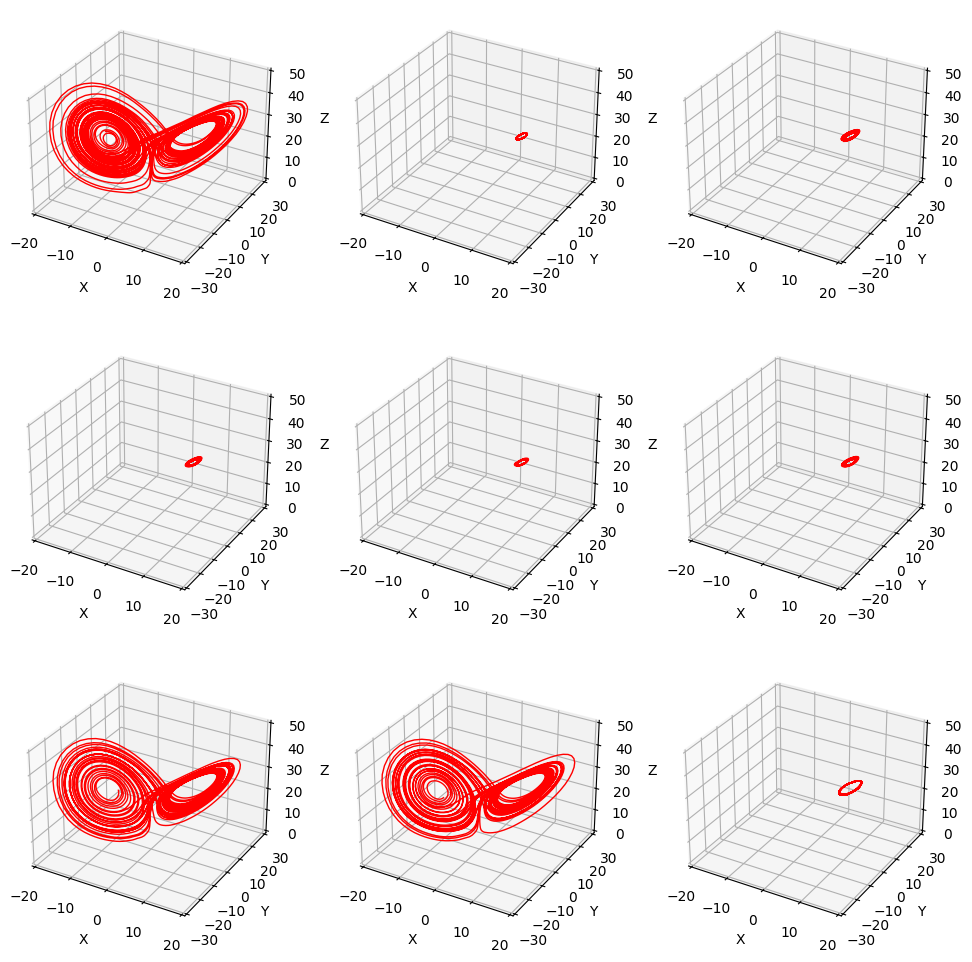

In [38]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

STEPS_TO_PLOT = -1
for i, ax in enumerate(axs.flat):
    ax.plot(
        sup_1_emulator_trj_compensate_batch_size[i, :STEPS_TO_PLOT, 0],
        sup_1_emulator_trj_compensate_batch_size[i, :STEPS_TO_PLOT, 1],
        sup_1_emulator_trj_compensate_batch_size[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="red",
        label="Sup-1 Emulator Compensated Batch Size",
    )
    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

In [39]:
sup_1_maximal_values_compensate_batch_size = [
    find_maximum_z(trj) for trj in sup_1_emulator_trj_compensate_batch_size
]

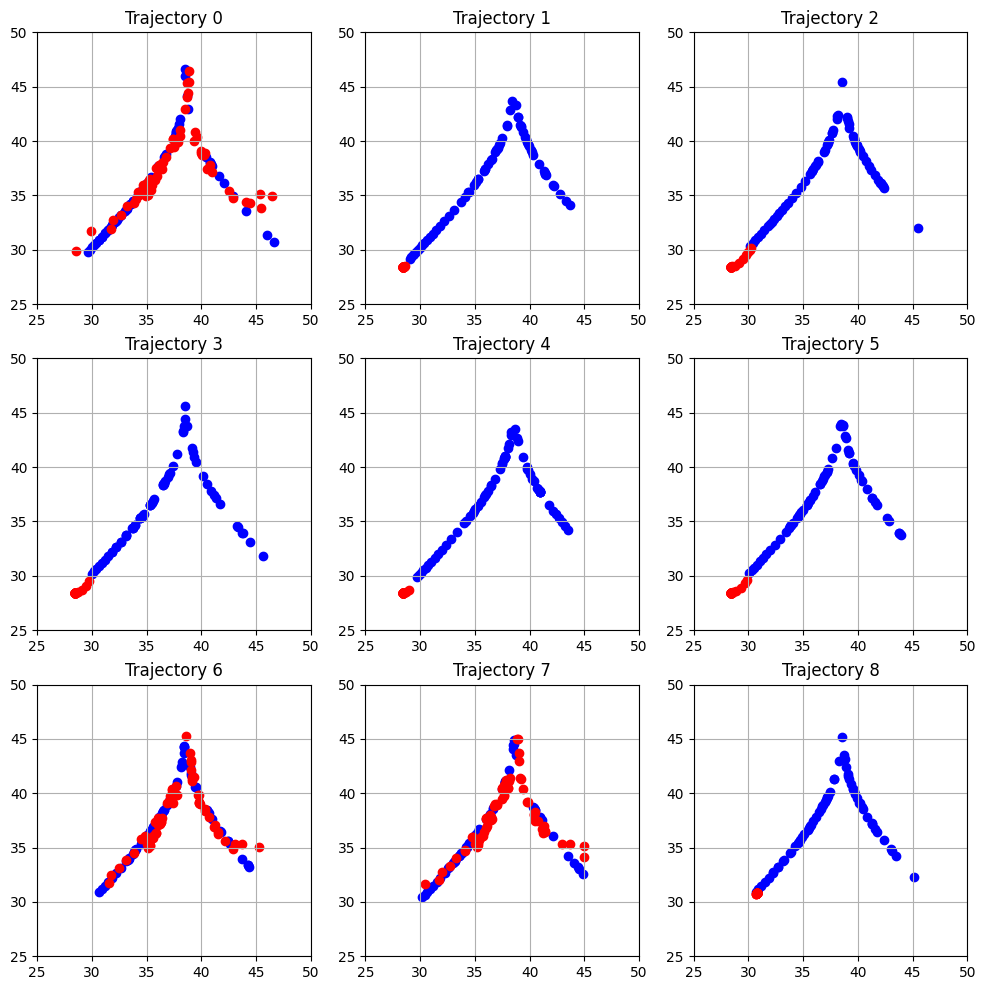

In [40]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    ax.scatter(
        maximal_values[i][:-1], maximal_values[i][1:], color="blue", label="Reference"
    )
    ax.scatter(
        sup_1_maximal_values_compensate_batch_size[i][:-1],
        sup_1_maximal_values_compensate_batch_size[i][1:],
        color="red",
        label="Sup-1 Emulator Compensated Batch Size",
    )
    ax.set_title(f"Trajectory {i}")
    ax.set_xlim(25, 50)
    ax.set_ylim(25, 50)
    ax.grid()

## One-Step Supervised with compensated train time

In [41]:
sup_1_trainer_compensate_train_time = tx.trainer.SupervisedTrainer(
    lorenz_data_trj,
    optimizer=optax.adam(
        optax.warmup_cosine_decay_schedule(
            0.0,
            3e-4,
            3000 * 5,
            20000 * 5,
        )
    ),
    num_training_steps=20_000 * 5,
    batch_size=64,
    num_rollout_steps=1,
)

In [42]:
(
    sup_1_trained_emu_compensate_train_time,
    sup_1_loss_history_compensate_train_time,
) = sup_1_trainer_compensate_train_time(emulator, jax.random.PRNGKey(0))

E: 00000, B: 00000:   0%|          | 0/100000 [00:00<?, ?it/s]

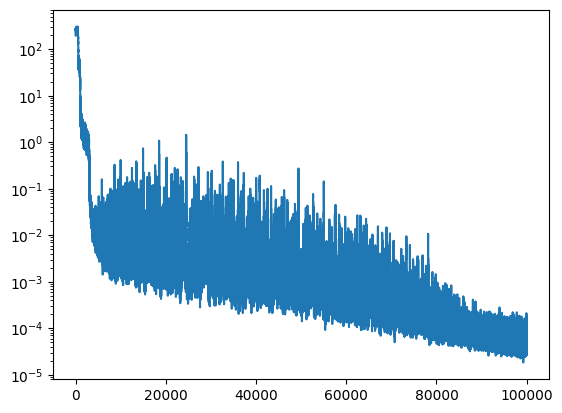

In [43]:
plt.semilogy(sup_1_loss_history_compensate_train_time)

In [44]:
sup_1_emulator_trj_compensate_train_time = jax.vmap(
    rollout(
        sup_1_trained_emu_compensate_train_time,
        lorenz_data_trj.shape[1] - 1,
        include_init=True,
    )
)(lorenz_data_trj[:, 0, :])

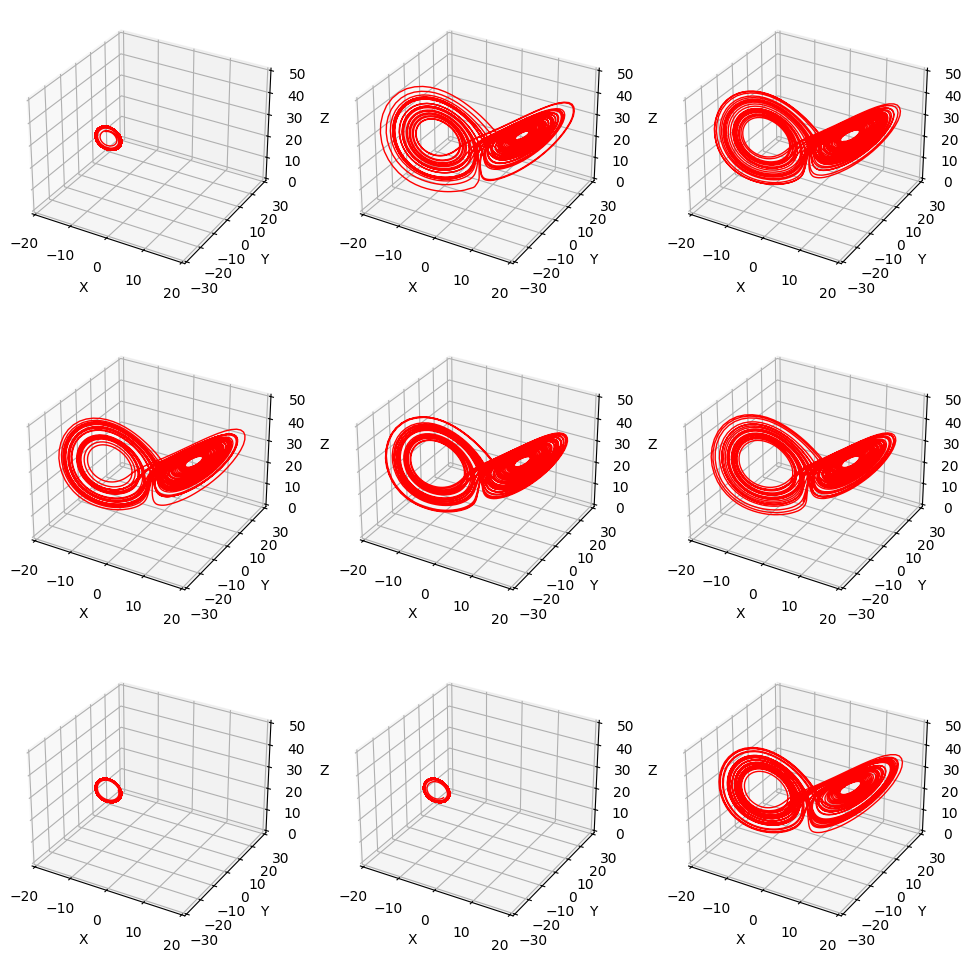

In [45]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

STEPS_TO_PLOT = -1

for i, ax in enumerate(axs.flat):
    ax.plot(
        sup_1_emulator_trj_compensate_train_time[i, :STEPS_TO_PLOT, 0],
        sup_1_emulator_trj_compensate_train_time[i, :STEPS_TO_PLOT, 1],
        sup_1_emulator_trj_compensate_train_time[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="red",
        label="Sup-1 Emulator Compensated Train Time",
    )
    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

In [46]:
sup_1_maximal_values_compensate_train_time = [
    find_maximum_z(trj) for trj in sup_1_emulator_trj_compensate_train_time
]

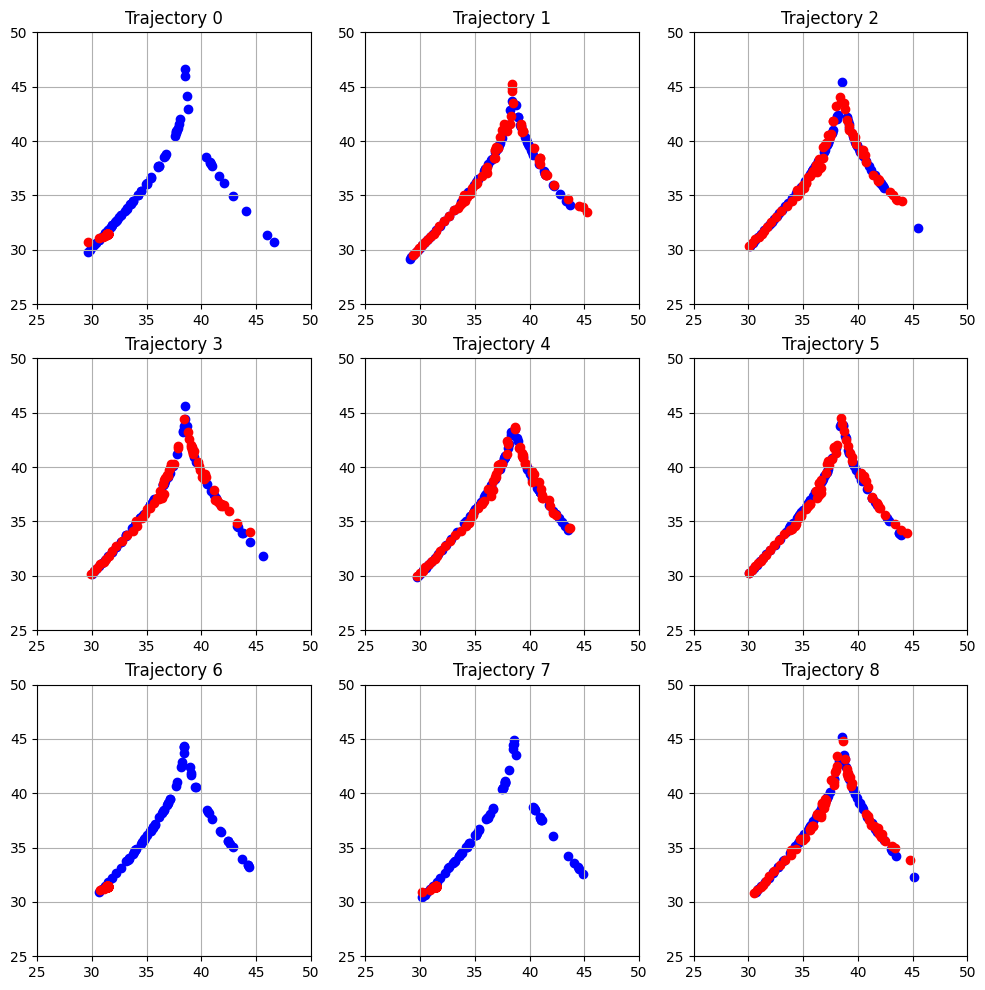

In [47]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    ax.scatter(
        maximal_values[i][:-1], maximal_values[i][1:], color="blue", label="Reference"
    )
    ax.scatter(
        sup_1_maximal_values_compensate_train_time[i][:-1],
        sup_1_maximal_values_compensate_train_time[i][1:],
        color="red",
        label="Sup-1 Emulator Compensated Train Time",
    )
    ax.set_title(f"Trajectory {i}")
    ax.set_xlim(25, 50)
    ax.set_ylim(25, 50)
    ax.grid()